In [1]:
import json
import json_helper as jhlp
import os
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.stats as scistat
plt.style.use('ggplot')

In [2]:
movies = ['Kill Bill Volume 1 & 2', 'A Few Good Men', 'Girl with the Dragon Tattoo, The','Avengers, The', 'Fight Club', 'Twiligh',
                 'Pirates of the Caribbean', 'Pirates of the Caribbean: Dead Man\'s Ches']
json_path = "path to json files"
movie_jsons = [json_path+'/'+movie+'.json' for movie in movies]
script_dicts = []
for movie_json in movie_jsons:
    with open(movie_json) as f:
        script_dicts.append(json.loads(f.read()))

In [3]:
#find character interactions for a scene
def get_chars_for_scene(scene, all_char_list):
    chars_from_desc = set()
    chars_from_dialogue = set()
    desc = jhlp.get_description_for_scene(scene)
    for c in all_char_list:
        if c in desc:
            chars_from_desc.add(c)
    for d in scene['char_dialogues']:
        if d[1] in all_char_list:
            chars_from_dialogue.add(d[1])
    return list(chars_from_desc), list(chars_from_dialogue)

In [4]:
#graph formation method I
graphs = []
for script_dict in script_dicts:
    all_char_list = jhlp.get_all_char_from_script(script_dict)
    graph = nx.Graph()
    for key in script_dict:
        scene = script_dict[key]
        a, b = get_chars_for_scene(scene, all_char_list)
        for char1 in b:
            for char2 in b:
                if char1 == char2:
                    continue
                if not graph.has_edge(char1, char2):
                    graph.add_edge(char1, char2, weight=1)
                else:
                    graph[char1][char2]['weight'] += 1
    graphs.append(graph)

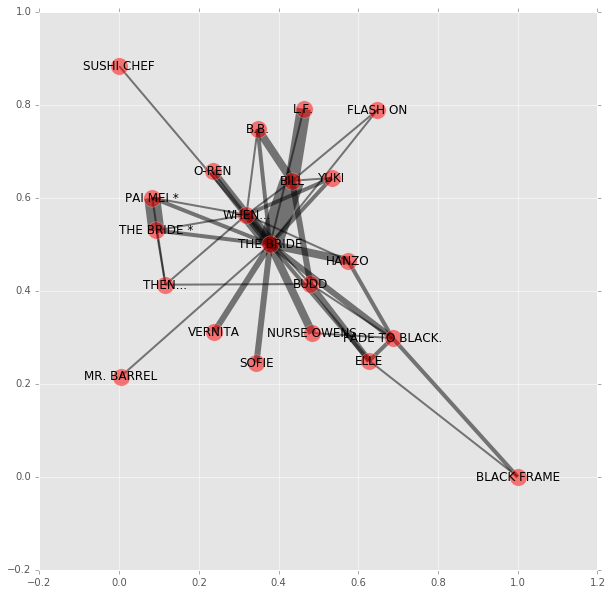

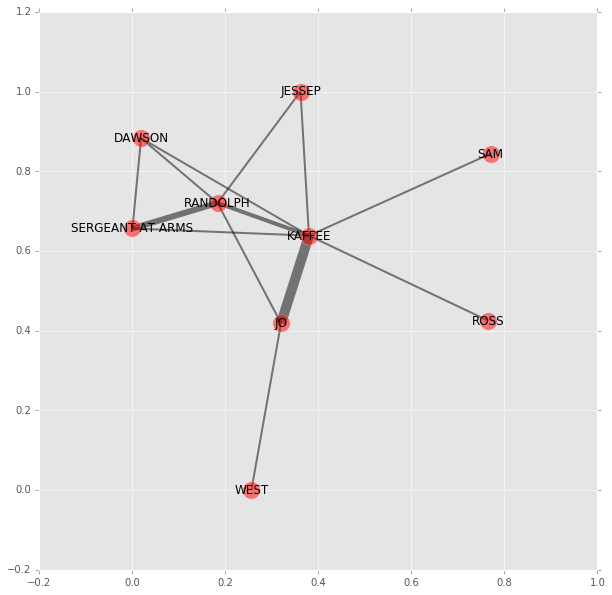

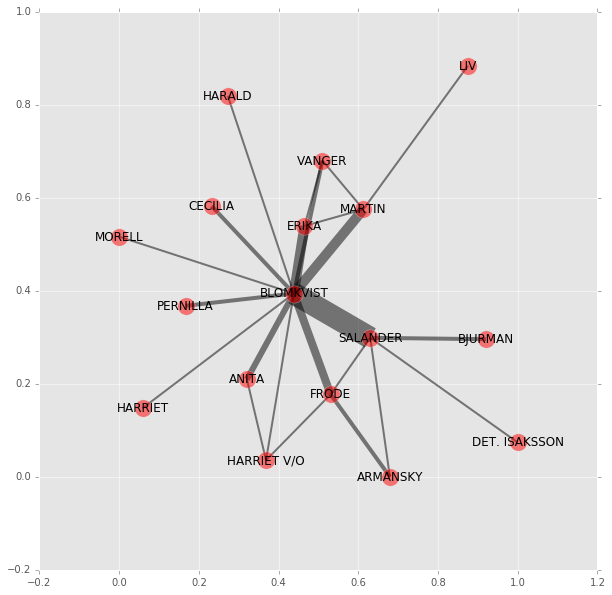

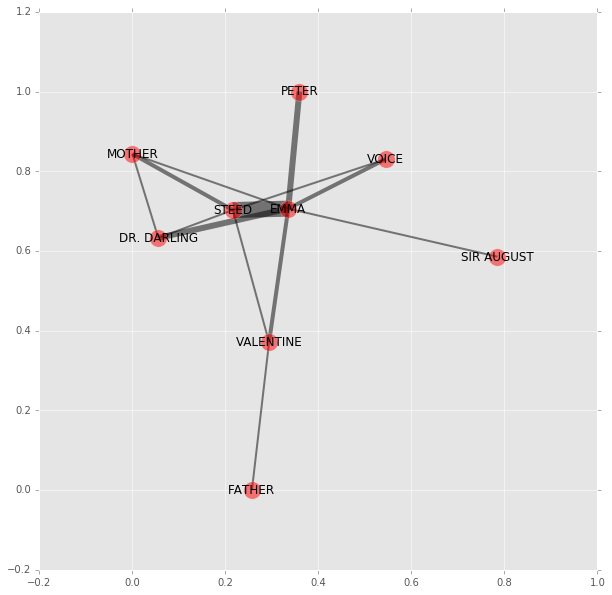

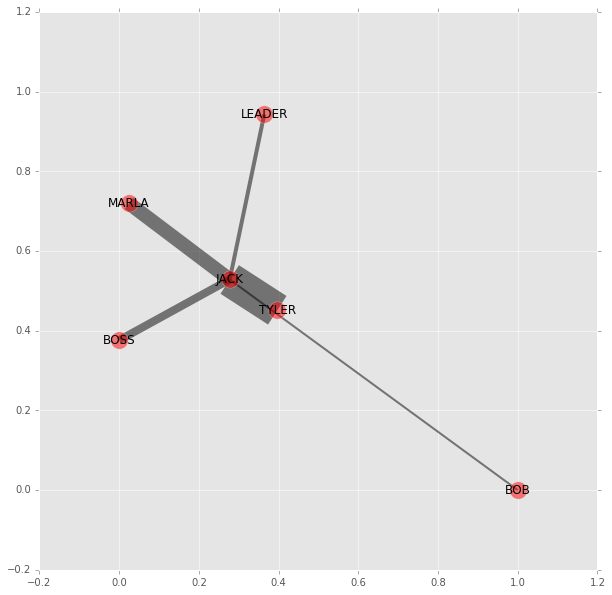

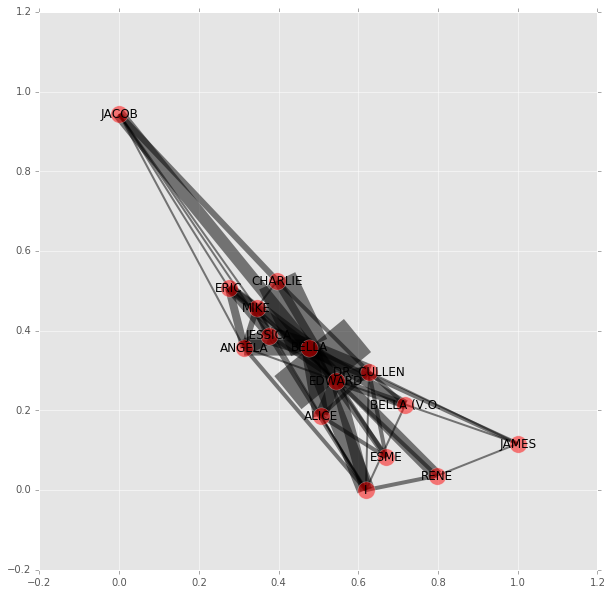

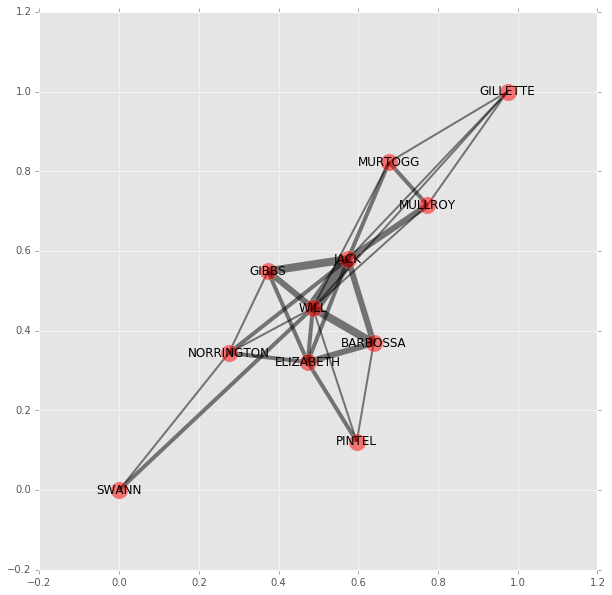

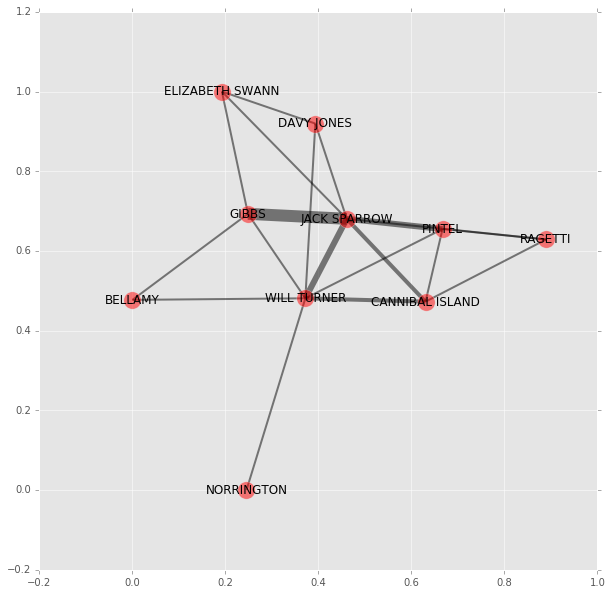

In [10]:
for graph in graphs:
    edge_weights = [graph[u][v]['weight'] for u,v in graph.edges()]
    pos = nx.spectral_layout(graph)
    plt.figure(figsize=(10,10))
    nx.draw_networkx(graph, with_labels=True, width=edge_weights, alpha=0.5); plt.show()

In [7]:
#graph formation method II
def get_char_interactions_for_scene_new(scene):
    interactions = []
    char_dialogues = scene['char_dialogues']
    if len(char_dialogues) < 2: #if a scene has less than two characters
        return interactions
    for i in range(len(char_dialogues)):
        for j in range(i, len(char_dialogues)):
            if i == j or j-i > 3:
                continue
            m = j-i
            weight = 4-m
            char1 = char_dialogues[i][1]
            char2 = char_dialogues[j][1]
            interactions.append((char1, char2, weight))
    return interactions
        
graphs_new = []    
for script_dict in script_dicts: 
    graph_new = nx.Graph()
    for scene_id in script_dict:
        scene = script_dict[scene_id]
        scene_interactions = get_char_interactions_for_scene_new(scene)
        for interaction in scene_interactions:
            char1 = interaction[0]
            char2 = interaction[1]
            wt = interaction[2]
            if not graph_new.has_edge(char1, char2):
                graph_new.add_edge(char1, char2, weight=wt)
            else:
                graph_new[char1][char2]['weight'] += wt 
    graphs_new.append(graph_new)

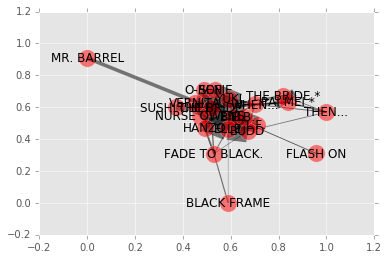

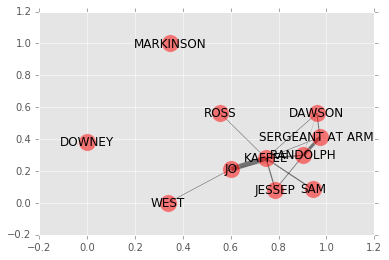

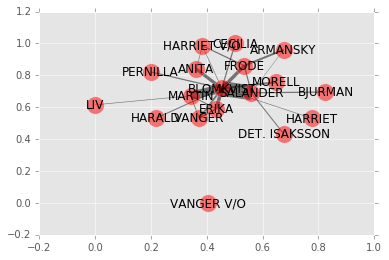

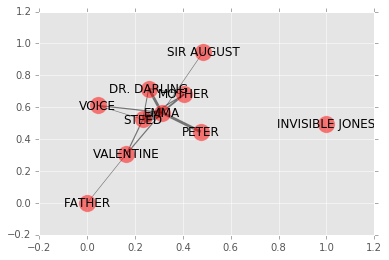

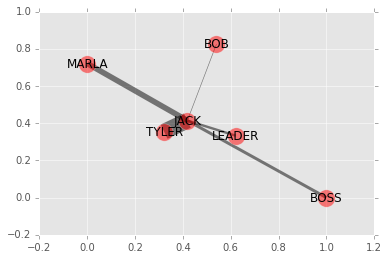

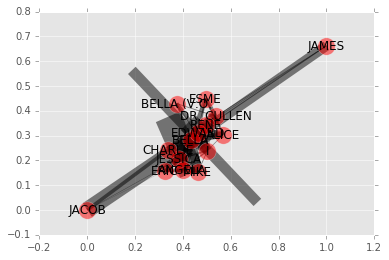

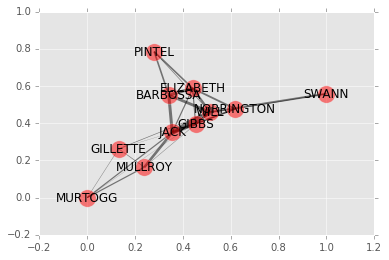

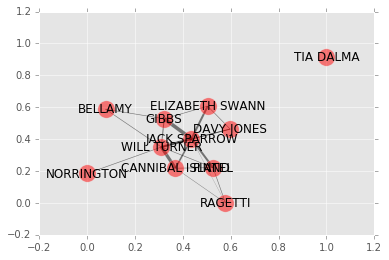

In [9]:
for graph_new in graphs_new:
    edge_weights = [float(graph_new[u][v]['weight'])/5 for u,v in graph_new.edges()]
    pos = nx.spectral_layout(graph_new)
    plt.figure()
    nx.draw_networkx(graph_new, with_labels=True, width=edge_weights, alpha=0.5); plt.show()

In [29]:
def get_graph_metrics(graph):
    num_chars = len(graph.nodes()) #1
    num_relations = len(graph.edges()) #2
    avg_clustering = nx.average_clustering(graph) #3
    per_node_centrality = sorted(np.array(nx.degree_centrality(graph_new).values()), reverse=True)
    centralization = sum(per_node_centrality[0] - per_node_centrality)/((num_chars-1)*(num_chars-2)) #4
    sing_char_centrality = (per_node_centrality[0] - per_node_centrality[1])/sum(per_node_centrality) #5
    edge_weights = sorted([float(graph[u][v]['weight'])/5 for u,v in graph.edges()], reverse=True)
    single_relationship_centrality = (edge_weights[0]-edge_weights[1])/sum(edge_weights) #6
    degrees = graph_new.degree(graph_new.nodes(), weight='weight').values()
    degrees = np.array(degrees)/sum(edge_weights)
    k = min(10, num_chars)
    top_char_degree_var = np.var(sorted(degrees, reverse=True)[:k]) #7
    k = min(10, len(e_weights))
    top_relationship_var = np.var(edge_weights[:k]) #8
    return [num_chars, num_relations, avg_clustering, centralization, sing_char_centrality, 
                   single_relationship_centrality, top_char_degree_var, top_relationship_var]

In [30]:
print get_graph_metrics(graph_new)

[18, 18, 0.16666666666666666, 0.0077854671280276821, 0.0, 0.021052631578947375, 0.22551246537396122, 0.12360000000000004]


In [23]:
#graph metrics
avg_clustering = nx.average_clustering(graph_new)
degree_centrality = nx.degree_centrality(graph_new)
print "average clustering :", avg_clustering
per_node_cent = np.array(degree_centrality.values())
centralization = sum(max(per_node_cent) - per_node_cent)/((len(graph_new.nodes())-1)*(len(graph_new.nodes())-2))
print "centralization :", centralization

average clustering : 0.166666666667
centralization : 0.00778546712803


In [28]:
#metrics as given in the paper
#single character cetrality
temp = sorted(per_node_cent, reverse=True)
sing_char_cent = (temp[0]-temp[1])/sum(per_node_cent)
print sing_char_cent

0.0


In [31]:
#single reationship centrality
sing_rel_cent = (sorted(edge_weights, reverse=True)[0]\
                -sorted(edge_weights, reverse=True)[1])\
                /sum(edge_weights)
print sing_rel_cent

0.0210526315789


In [32]:
#top character weight variance
degrees = graph_new.degree(graph_new.nodes(), weight='weight').values()
degrees = np.array(degrees)/sum(edge_weights)
k = min(10, len(graph_new.nodes()))
top_degrees = sorted(degrees, reverse=True)[:k]
char_degree_var = np.var(top_degrees)
print char_degree_var
#needs normalization??
#normalize by the sum of degrees

0.225512465374


In [33]:
#top relationship strength variance
e_weights = np.array(edge_weights)/sum(edge_weights)
k = min(10, len(e_weights))
top_e_weights = sorted(e_weights, reverse=True)[:k]
relationship_variance = np.var(top_e_weights)
print relationship_variance

0.000342382271468
